In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import messagebox
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


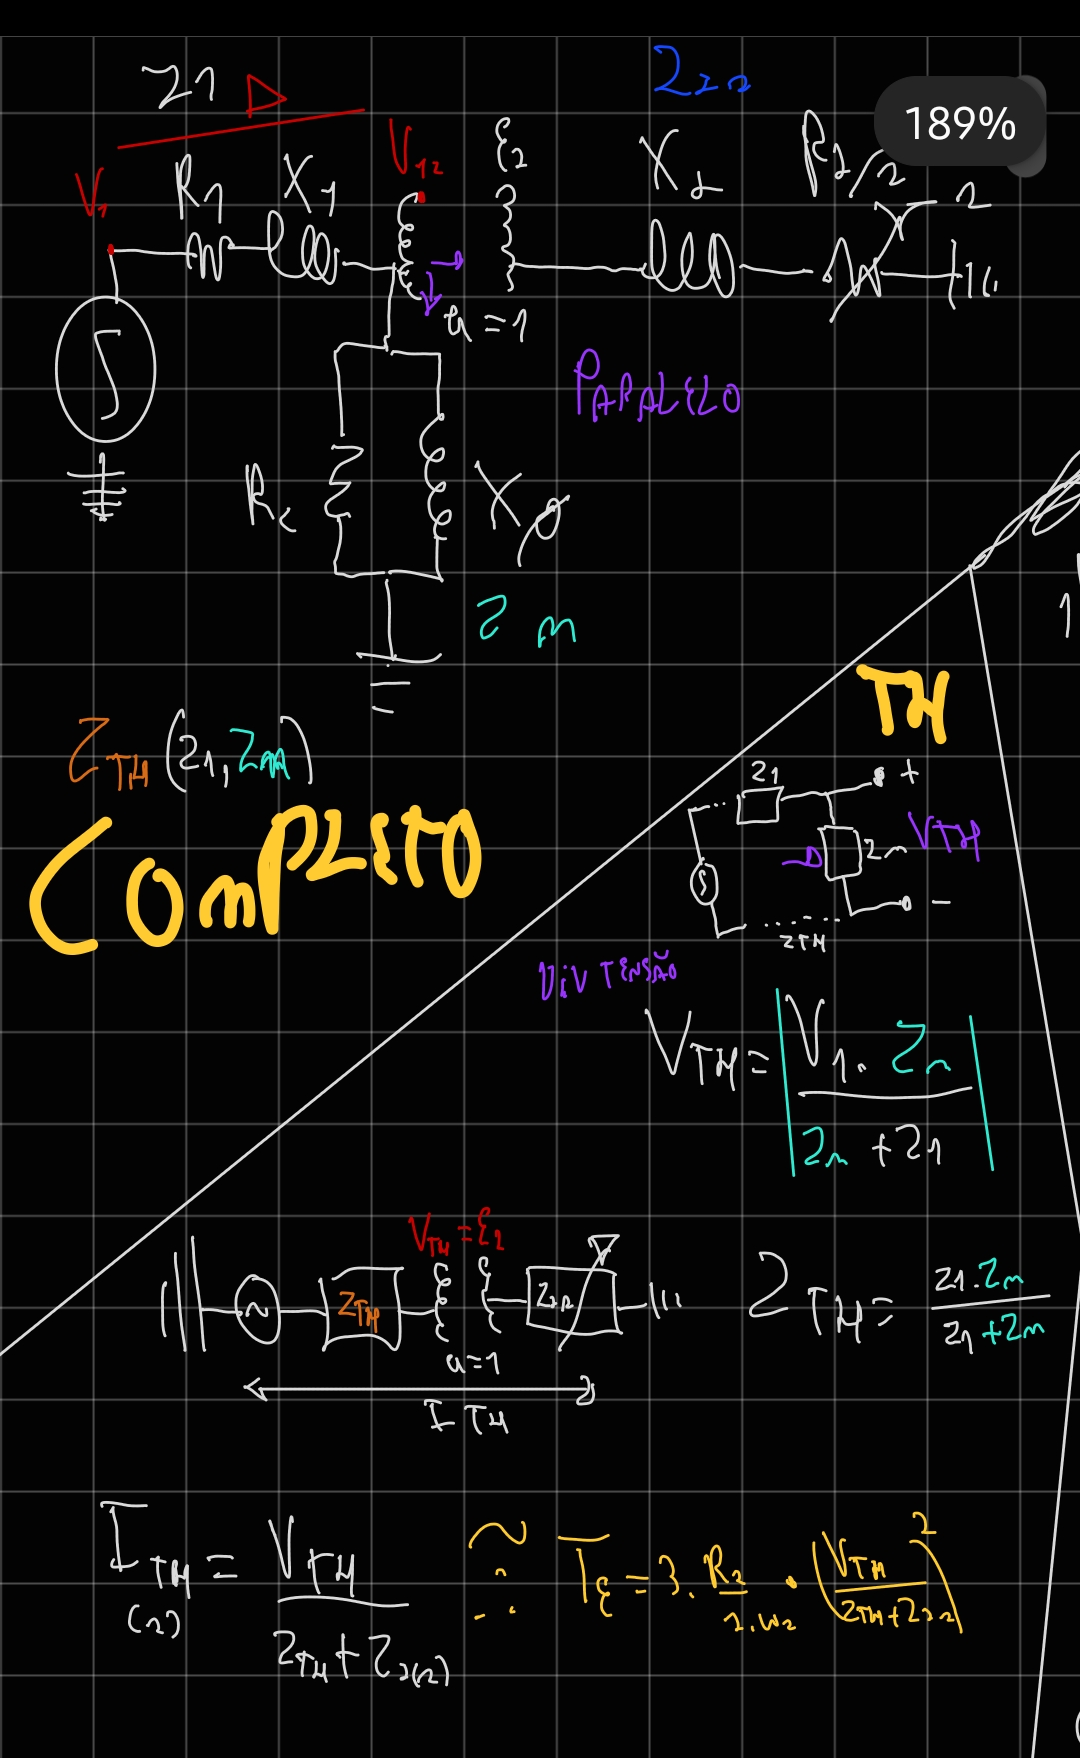

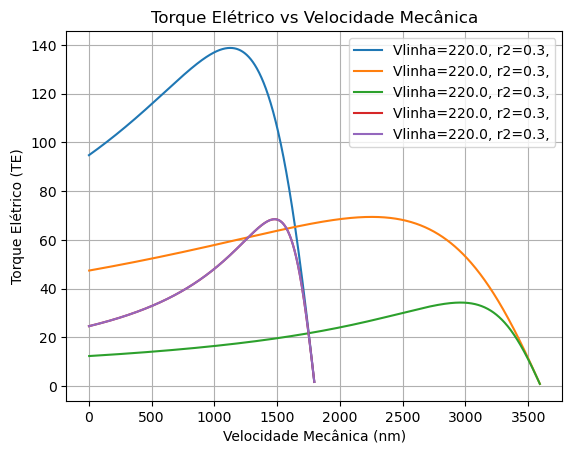

In [3]:

# Função para configuração Y ou Triângulo
def Tensao_Y_T(configuracao, Vlinha):
    if configuracao == 'Y':
        Vfase = Vlinha / np.sqrt(3)
    elif configuracao == 'T':
        Vfase = Vlinha
    return Vfase

# Função para calcular o circuito equivalente
def circuito_equivalente(Vfase, configuracao, r1, x1, rc, r2, x2, xm, ws, ns):
    Z1 = complex(r1, x1)
    s_values = np.arange(0.999, 0.001, -0.001)  # Escorregamento variando de 1 a 0 com passo de 0.001
    nm_values = []
    wm_values = []
    torque_values = []
    eficiencia_values = []
    Pout_values = []
    TE_values = []
    FP_values = []
    for s in s_values:
        nm = ns * (1 - s)  # Velocidade mecânica
        wm = ws * (1 - s)  # Velocidade angular mecânica
        Zm = rc * 1j * xm / (rc + 1j * xm)
        Z2 = r2 / s + 1j * x2
        Z2m = (Zm * Z2) / (Zm + Z2)
        Ztotal = Z1 + Z2m
        I1fase = Vfase / Ztotal
        I2fase = I1fase * Z2m / Z2  # divisor de corrente
        Im = I1fase - I2fase
        Ic = Im * 1j * xm / (rc + 1j * xm)  # divisor de corrente
        
        if configuracao == 'Y':
            Ilinha = I1fase 
        elif configuracao == 'T':
            Ilinha = I1fase * np.sqrt(3)
        
        Sin = 3 * Vfase * np.abs(I1fase)
        theta = np.angle(Ztotal, deg=False)  # rad
        FP = np.cos(theta)  # fator de potência
        Pin = Sin * FP
        Pgap = 3 * (r2 / s) * np.abs(I2fase) ** 2
        Pcobre = 3 * r1 * np.abs(I1fase) ** 2
        Pcore = 3 * rc * np.abs(Ic) ** 2
        Pmec = Pgap * (1 - s) - Pcobre - Pcore
        Pout = Pmec
        TMout = (Pout / wm)  # torque mecânico
        TE = ((3 * (r2 / s) * np.abs(I2fase) ** 2) / ws)
        eficienciaM = np.abs(Pout / Pin)  # eficiência
        
        # Armazenar valores
        TE_values.append(TE)
        nm_values.append(nm)
        wm_values.append(wm)
        FP_values.append(FP)
        Pout_values.append(Pout)
        torque_values.append(TMout)
        eficiencia_values.append(eficienciaM)
    
    # Identificar índices de torque e eficiência máximos
    maxE_torque_idx = np.argmax(TE_values)  # Índice do torque E máximo
    maxm_torque_idx = np.argmax(torque_values)  # Índice do torque mecânico máximo
    max_eficiencia_idx = np.argmax(eficiencia_values)  # Índice da eficiência máxima
    max_FP_idx = np.argmax(FP_values)
    max_Pout_idx = np.argmax(Pout_values)
    
    # Obter os valores de torque e eficiência máximos
    max_torqueE = max(TE_values)
    max_torquem = max(torque_values)
    max_eficiencia = max(eficiencia_values)
    max_FP = max(FP_values)
    max_Pout = max(Pout_values)
    # Obter o torque inicial 
    torque_inicial = TE_values[0]  # Primeiro valor do array de torque
    
    # Obter o valor de s associado 
    s_torque_maxE = s_values[maxE_torque_idx]
    s_torque_maxm = s_values[maxm_torque_idx]
    s_eficiencia_max = s_values[max_eficiencia_idx]
    
    return max_torquem, max_eficiencia, s_torque_maxE, s_torque_maxm, s_eficiencia_max, torque_inicial, max_FP, max_Pout, nm_values, torque_values, max_torqueE, TE_values

# Função do botão calcular
def calcular():
    try:
        configuracao = config_var.get()
        Vlinha = float(entry_vlinha.get())
        r1 = float(entry_r1.get())
        x1 = float(entry_x1.get())
        rc = float(entry_rc.get())
        r2 = float(entry_r2.get())
        x2 = float(entry_x2.get())
        xm = float(entry_xm.get())
        frequencia = float(entry_frequencia.get())
        polos = int(entry_polos.get())

        # Cálculos de frequência síncrona
        w = 2 * np.pi * frequencia
        ws = 2 * w / polos
        ns = 30 * ws / np.pi

        Vfase = Tensao_Y_T(configuracao, Vlinha)

        # Chamar a função de circuito equivalente
        max_torque, max_eficiencia, s_torque_maxE, s_torque_maxm, s_eficiencia_max, torque_inicial, max_FP, max_Pout, nm_values, torqueM_values, max_torqueE, TE_values = circuito_equivalente(
            Vfase, configuracao, r1, x1, rc, r2, x2, xm, ws, ns)
        
        # Exibir os resultados na interface
        label_result_tmout.config(text=f"{max_torque:.2f}")
        label_result_eficiencia.config(text=f"{max_eficiencia:.2f}")
        label_result_s_torque_max.config(text=f"{s_torque_maxE:.3f}")
        label_result_s_torque_maxM.config(text=f"{s_torque_maxm:.3f}")
        
        label_result_s_eficiencia_max.config(text=f"{s_eficiencia_max:.3f}")
        label_result_torque_inicial.config(text=f"{torque_inicial:.2f}")
        label_result_FPMAX.config(text=f"{max_FP:.2f}")
        label_result_PoutMAX.config(text=f"{max_Pout:.2f}")
        label_result_tEout.config(text=f"{max_torqueE:.2f}")
        # Plotar Torque Mecânico (TMout) vs Velocidade Mecânica (nm)
        ax.plot(nm_values, TE_values, label=f'Vlinha={Vlinha}, r2={r2},')
        ax.set_xlabel('Velocidade Mecânica (nm)')
        ax.set_ylabel('Torque Elétrico (TE)')
        ax.set_title('Torque Elétrico vs Velocidade Mecânica')
        ax.legend()
        ax.grid(True)
        canvas.draw()
        
    except ValueError:
        messagebox.showerror("Erro", "Insira valores numéricos válidos.")

###############  Apartir ############################################################
# Interface Gráfica com Tkinter
root = tk.Tk()
root.title("Calculadora de Circuito Equivalente")

# Parâmetros de entrada
tk.Label(root, text="Configuração (Y/T)").grid(row=0, column=0)
config_var = tk.StringVar(value='Y')
tk.Entry(root, textvariable=config_var).grid(row=0, column=1)

tk.Label(root, text="Vlinha").grid(row=1, column=0)
entry_vlinha = tk.Entry(root)
entry_vlinha.grid(row=1, column=1)

tk.Label(root, text="r1").grid(row=2, column=0)
entry_r1 = tk.Entry(root)
entry_r1.grid(row=2, column=1)

tk.Label(root, text="x1").grid(row=3, column=0)
entry_x1 = tk.Entry(root)
entry_x1.grid(row=3, column=1)

tk.Label(root, text="rc").grid(row=4, column=0)
entry_rc = tk.Entry(root)
entry_rc.grid(row=4, column=1)

tk.Label(root, text="r2").grid(row=5, column=0)
entry_r2 = tk.Entry(root)
entry_r2.grid(row=5, column=1)

tk.Label(root, text="x2").grid(row=6, column=0)
entry_x2 = tk.Entry(root)
entry_x2.grid(row=6, column=1)

tk.Label(root, text="xm").grid(row=7, column=0)
entry_xm = tk.Entry(root)
entry_xm.grid(row=7, column=1)

tk.Label(root, text="Frequência").grid(row=8, column=0)
entry_frequencia = tk.Entry(root)
entry_frequencia.grid(row=8, column=1)

tk.Label(root, text="Polos").grid(row=9, column=0)
entry_polos = tk.Entry(root)
entry_polos.grid(row=9, column=1)

##################### Resultados
tk.Label(root, text="Torque Máximo mecanico (Nm)").grid(row=1, column=3)
label_result_tmout = tk.Label(root, text="0.0")
label_result_tmout.grid(row=1, column=4)

tk.Label(root, text="s com Torque Máximo mecanico").grid(row=2, column=3)
label_result_s_torque_maxM = tk.Label(root, text="0.0")
label_result_s_torque_maxM.grid(row=2, column=4)

tk.Label(root, text="Eficiência Máxima").grid(row=3, column=3)
label_result_eficiencia = tk.Label(root, text="0.0")
label_result_eficiencia.grid(row=3, column=4)

tk.Label(root, text="s com Torque Máximo eletrico").grid(row=5, column=3)
label_result_s_torque_max = tk.Label(root, text="0.0")
label_result_s_torque_max.grid(row=5, column=4)



tk.Label(root, text="s com Eficiência Máxima").grid(row=4, column=3)
label_result_s_eficiencia_max = tk.Label(root, text="0.0")
label_result_s_eficiencia_max.grid(row=4, column=4)

tk.Label(root, text="Torque Inicial (s=1)").grid(row=6, column=3)
label_result_torque_inicial = tk.Label(root, text="0.0")
label_result_torque_inicial.grid(row=6, column=4)

tk.Label(root, text="FP max").grid(row=9, column=3)
label_result_FPMAX = tk.Label(root, text="0.0")
label_result_FPMAX.grid(row=9, column=4)

tk.Label(root, text="Pout max (W)").grid(row=7, column=3)
label_result_PoutMAX = tk.Label(root, text="0.0")
label_result_PoutMAX.grid(row=7, column=4)

tk.Label(root, text="Torque eletrico max (Nm)").grid(row=8, column=3)
label_result_tEout = tk.Label(root, text="0.0")
label_result_tEout.grid(row=8, column=4)

# Botão de calcular
tk.Button(root, text="Calcular", command=calcular).grid(row=10, column=0, columnspan=2)

# Configuração do gráfico
fig, ax = plt.subplots()
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().grid(row=10, column=5, columnspan=2)

root.mainloop()

O DE CIMA EH O CERTO N MEXER

De baixo eh o de medicoes mas nao sei pq nao vai


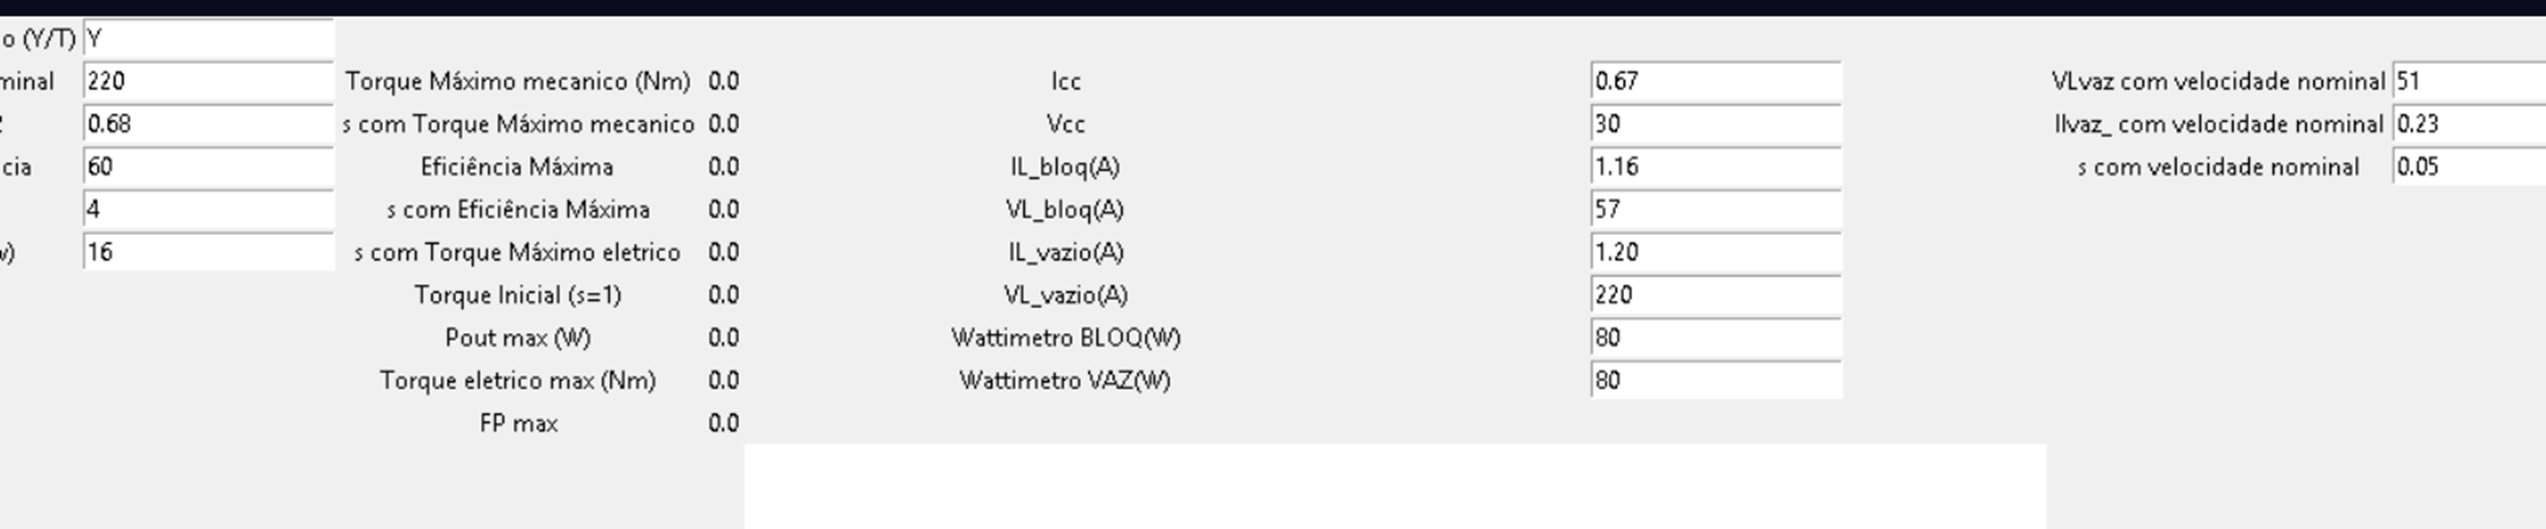

Teoricamente esses valores eram para dar certo

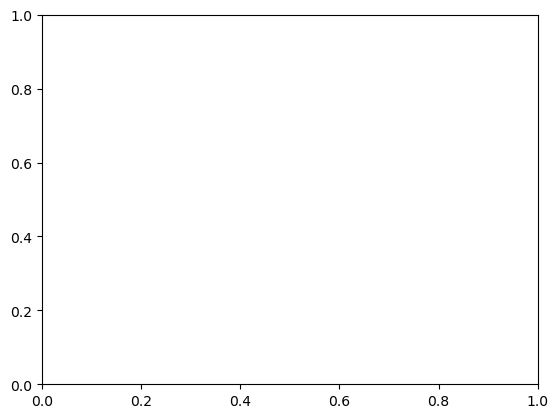

In [9]:

# Função para configuração Y ou Triângulo
def Tensao_Y_T(configuracao, Vlinha, Ilinha):
    if configuracao == 'Y':
        Vfase = Vlinha / np.sqrt(3)
        Ifase = Ilinha 
    elif configuracao == 'T':
        Vfase = Vlinha
        Ifase = Ilinha / np.sqrt(3)
    return Vfase, Ifase

# Função para calcular Teste de medicoes   
def teste_medicoes(configuracao, IL_bloq, Vlinha_bloq, Vlinha_vaz, IL_VAZIO, Icc, Vcc, X1_x2, Prot, Wt_vaz, Wt_bloq, VLvaz_vsnom, Ilvaz_vnom, snominal):
    sbloq = 1
    svazio = 0
    nmbloq = 0
    nmvazio = 1
    Vfasebloq, Ifasebloq = Tensao_Y_T(configuracao, Vlinha_bloq, IL_bloq)
    Vfasevazio, Ifasevazio = Tensao_Y_T(configuracao, Vlinha_vaz, IL_VAZIO)
    I2_bloq = Ifasebloq
    IM_vazio = Ifasevazio
    
    r1 = Vcc / Icc
    Pincc = Vcc * Icc  
    Sbloq = I2_bloq * 3 * Vfasebloq
    thetabloq = np.arccos((Wt_bloq) / Sbloq) #rad
    X1_MAISX2 = (Vfasevazio / IM_vazio) * np.sin(thetabloq) # rad
    x2 = X1_MAISX2 / (1 + X1_x2)
    x1 = X1_MAISX2 - x2
    # até aqui R1 X1 X2 BLOQ e CC
    # Teste de vazio 
    Pcobre = Wt_vaz - Prot
    rc = ((Vfasevazio ** 2) / Pcobre)
    xm = ((Vfasevazio ** 2) / Prot)
    # Teste vazio Velocidade nominal (achar R2)
    E1 = VLvaz_vsnom - (VLvaz_vsnom * (r1 + 1j * x1))
    Ic_vaznom = E1 / rc
    Imvaz_nom = E1 / (1j * xm)
    I2_v_nom = Ilvaz_vnom - (Ic_vaznom + Imvaz_nom)
    Z2vaz_vnom = E1 / I2_v_nom
    r2 = (np.sqrt((np.abs(Z2vaz_vnom)) ** 2 - np.abs(x2) ** 2)) * snominal
    
    s_values = np.arange(0.999, 0.001, -0.001)  # Escorregamento variando de 1 a 0 com passo de 0.001
    nm_values = []
    wm_values = []
    torque_values = []
    eficiencia_values = []
    Pout_values = []
    TE_values = []
    FP_values = []
    Z2_values = []
    
    for s in s_values:
        nm = ns * (1 - s)  # Velocidade mecânica
        wm = ws * (1 - s)  # Velocidade angular mecânica
        Zm = ((rc * 1j * xm) / (rc + 1j * xm))
        Z2 = ((r2 / s) + 1j * x2) 
        
        Z2m = (Zm * Z2) / (Zm + Z2)
        Ztotal = r1 + 1j * x1 + Z2m  # Define Z1 as r1 + 1j * x1
        I1fase = Vfasebloq / Ztotal
        I2fase = I1fase * Z2m / Z2  # divisor de corrente
        Im = I1fase - I2fase
        Ic = Im * 1j * xm / (rc + 1j * xm)  # divisor de corrente
        Ifhi = Im - Ic
                
        Sin = 3 * Vfasebloq * np.abs(I1fase)
        theta = np.angle(Ztotal, deg=False)  # rad
        FP = np.cos(theta)  # fator de potência
        Pin = Sin * FP
        Pgap = 3 * (r2 / s) * np.abs(I2fase) ** 2
        Pcobre = 3 * r1 * np.abs(I1fase) ** 2
        Pcore = 3 * rc * np.abs(Ic) ** 2
        Pmec = Pgap * (1 - s) - Pcobre - Pcore
        Pout = Pmec
        TMout = (Pout / wm)  # torque mecânico
        TE = ((3 * (r2 / s) * np.abs(I2fase) ** 2) / ws)
        eficienciaM = np.abs(Pout / Pin)  # eficiência
        
        # Armazenar valores
        TE_values.append(TE)
        nm_values.append(nm)
        wm_values.append(wm)
        FP_values.append(FP)
        Pout_values.append(Pout)
        torque_values.append(TMout)
        eficiencia_values.append(eficienciaM)
    
    # Identificar índices de torque e eficiência máximos
    maxE_torque_idx = np.argmax(TE_values)  # Índice do torque E máximo
    maxm_torque_idx = np.argmax(torque_values)  # Índice do torque mecânico máximo
    max_eficiencia_idx = np.argmax(eficiencia_values)  # Índice da eficiência máxima
    max_FP_idx = np.argmax(FP_values)
    max_Pout_idx = np.argmax(Pout_values)
    
    # Obter os valores de torque e eficiência máximos
    max_torqueE = max(TE_values)
    max_torquem = max(torque_values)
    max_eficiencia = max(eficiencia_values)
    max_FP = max(FP_values)
    max_Pout = max(Pout_values)
    # Obter o torque inicial 
    torque_inicial = TE_values[0]  # Primeiro valor do array de torque
    
    # Obter o valor de s associado 
    s_torque_maxE = s_values[maxE_torque_idx]
    s_torque_maxm = s_values[maxm_torque_idx]
    s_eficiencia_max = s_values[max_eficiencia_idx]
    
    return max_torquem, max_eficiencia, s_torque_maxE, s_torque_maxm, s_eficiencia_max, torque_inicial, max_FP, max_Pout, nm_values, torque_values, max_torqueE, TE_values,r2

# Função do botão calcular
def calcular():
    try:
        configuracao = config_var.get()
        Vlinha = float(entry_vlinha.get())
        Vcc = float(entry_Vcc.get())
        Icc = float(entry_Icc.get())
        IL_bloq = float(entry_IL_bloq.get())
        IL_VAZIO = float(entry_IL_VAZIO.get())
        frequencia = float(entry_frequencia.get())
        polos = int(entry_polos.get())
        X1_x2 = int(entry_x1x2.get())
        Prot = int(entry_Prot.get())    
        Wt_bloq = int(entry_Wt_bloq.get())  
        Wt_vaz = int(entry_Wt_vaz.get())  
        Vlinha_bloq = int(entry_Vlinha_bloq.get())
        Vlinha_vaz = int(entry_Vlinha_vaz.get())    
        VLvaz_vnom = int(entry_VLvaz_vnom.get())  
        Ilvaz_vnom = int(entry_Ilvaz_vnom.get())
        snominal = int(entry_snominal.get())     
        # Cálculos de frequência síncrona 
        w = 2 * np.pi * frequencia
        ws = 2 * w / polos
        ns = 30 * ws / np.pi

        # Chamar a função de Teste de medicoes
        max_torquem, max_eficiencia, s_torque_maxE, s_torque_maxm, s_eficiencia_max, torque_inicial, max_FP, max_Pout, nm_values, torque_values, max_torqueE, TE_values,r2 = teste_medicoes(configuracao, IL_bloq, Vlinha_bloq, Vlinha_vaz, IL_VAZIO, Icc, Vcc, X1_x2, Prot, Wt_vaz, Wt_bloq, VLvaz_vnom, Ilvaz_vnom, snominal)
        
        # Exibir os resultados na interface
        label_result_tmout.config(text=f"{max_torquem:.2f}")
        label_result_eficiencia.config(text=f"{max_eficiencia:.2f}")
        label_result_s_torque_max.config(text=f"{s_torque_maxE:.3f}")
        label_result_s_torque_maxM.config(text=f"{s_torque_maxm:.3f}")
        
        label_result_s_eficiencia_max.config(text=f"{s_eficiencia_max:.3f}")
        label_result_torque_inicial.config(text=f"{torque_inicial:.2f}")
        label_result_FPMAX.config(text=f"{max_FP:.2f}")
        label_result_PoutMAX.config(text=f"{max_Pout:.2f}")
        label_result_tEout.config(text=f"{max_torqueE:.2f}")
        # Plotar Torque Mecânico (TMout) vs Velocidade Mecânica (nm)
        ax.plot(nm_values, TE_values, label=f'Vlinha={Vlinha}, r2={r2}')
        ax.set_xlabel('Velocidade Mecânica (nm)')
        ax.set_ylabel('Torque Elétrico (TE)')
        ax.set_title('Torque Elétrico vs Velocidade Mecânica para testes')
        ax.legend()
        ax.grid(True)
        canvas.draw()
        
    except ValueError:
        messagebox.showerror("Erro", "Insira valores numéricos válidos.")

###############  Apartir ############################################################
# Interface Gráfica com Tkinter
root = tk.Tk()
root.title("Calculadora de Circuito Equivalente")

# Parâmetros de entrada
tk.Label(root, text="Configuração (Y/T)").grid(row=0, column=0)
config_var = tk.StringVar(value='Y')
tk.Entry(root, textvariable=config_var).grid(row=0, column=1)

tk.Label(root, text="Vlinha nominal").grid(row=1, column=0)
entry_vlinha = tk.Entry(root)
entry_vlinha.grid(row=1, column=1)

tk.Label(root, text="X1/X2").grid(row=2, column=0)
entry_x1x2 = tk.Entry(root)
entry_x1x2.grid(row=2, column=1)

tk.Label(root, text="Frequência").grid(row=3, column=0)
entry_frequencia = tk.Entry(root)
entry_frequencia.grid(row=3, column=1)

tk.Label(root, text="Polos").grid(row=4, column=0)
entry_polos = tk.Entry(root)
entry_polos.grid(row=4, column=1)

tk.Label(root, text="Prot (w)").grid(row=5, column=0)
entry_Prot = tk.Entry(root)
entry_Prot.grid(row=5, column=1)

tk.Label(root, text="Icc").grid(row=1, column=5)
entry_Icc = tk.Entry(root)
entry_Icc.grid(row=1, column=6)

tk.Label(root, text="Vcc").grid(row=2, column=5)
entry_Vcc = tk.Entry(root)
entry_Vcc.grid(row=2, column=6)

tk.Label(root, text="IL_bloq(A)").grid(row=3, column=5)
entry_IL_bloq = tk.Entry(root)
entry_IL_bloq.grid(row=3, column=6)

tk.Label(root, text="VL_bloq(A)").grid(row=4, column=5)
entry_Vlinha_bloq = tk.Entry(root)
entry_Vlinha_bloq.grid(row=4, column=6)

tk.Label(root, text="IL_vazio(A)").grid(row=5, column=5)
entry_IL_VAZIO = tk.Entry(root)
entry_IL_VAZIO.grid(row=5, column=6)

tk.Label(root, text="VL_vazio(A)").grid(row=6, column=5)
entry_Vlinha_vaz = tk.Entry(root)
entry_Vlinha_vaz.grid(row=6, column=6)

tk.Label(root, text="Wattimetro BLOQ(W)").grid(row=7, column=5)
entry_Wt_bloq = tk.Entry(root)
entry_Wt_bloq.grid(row=7, column=6)

tk.Label(root, text="Wattimetro VAZ(W)").grid(row=8, column=5)
entry_Wt_vaz = tk.Entry(root)
entry_Wt_vaz.grid(row=8, column=6)

tk.Label(root, text="VLvaz com velocidade nominal").grid(row=1, column=7)
entry_VLvaz_vnom = tk.Entry(root)
entry_VLvaz_vnom.grid(row=1, column=8)

tk.Label(root, text="Ilvaz_ com velocidade nominal").grid(row=2, column=7)
entry_Ilvaz_vnom = tk.Entry(root)
entry_Ilvaz_vnom.grid(row=2, column=8)

tk.Label(root, text="s com velocidade nominal").grid(row=3, column=7)
entry_snominal = tk.Entry(root)
entry_snominal.grid(row=3, column=8)

##################### Resultados
tk.Label(root, text="Torque Máximo mecanico (Nm)").grid(row=1, column=3)
label_result_tmout = tk.Label(root, text="0.0")
label_result_tmout.grid(row=1, column=4)

tk.Label(root, text="s com Torque Máximo mecanico").grid(row=2, column=3)
label_result_s_torque_maxM = tk.Label(root, text="0.0")
label_result_s_torque_maxM.grid(row=2, column=4)

tk.Label(root, text="Eficiência Máxima").grid(row=3, column=3)
label_result_eficiencia = tk.Label(root, text="0.0")
label_result_eficiencia.grid(row=3, column=4)

tk.Label(root, text="s com Torque Máximo eletrico").grid(row=5, column=3)
label_result_s_torque_max = tk.Label(root, text="0.0")
label_result_s_torque_max.grid(row=5, column=4)

tk.Label(root, text="s com Eficiência Máxima").grid(row=4, column=3)
label_result_s_eficiencia_max = tk.Label(root, text="0.0")
label_result_s_eficiencia_max.grid(row=4, column=4)

tk.Label(root, text="Torque Inicial (s=1)").grid(row=6, column=3)
label_result_torque_inicial = tk.Label(root, text="0.0")
label_result_torque_inicial.grid(row=6, column=4)

tk.Label(root, text="FP max").grid(row=9, column=3)
label_result_FPMAX = tk.Label(root, text="0.0")
label_result_FPMAX.grid(row=9, column=4)

tk.Label(root, text="Pout max (W)").grid(row=7, column=3)
label_result_PoutMAX = tk.Label(root, text="0.0")
label_result_PoutMAX.grid(row=7, column=4)

tk.Label(root, text="Torque eletrico max (Nm)").grid(row=8, column=3)
label_result_tEout = tk.Label(root, text="0.0")
label_result_tEout.grid(row=8, column=4)

# Botão de calcular
tk.Button(root, text="Calcular", command=calcular).grid(row=10, column=0, columnspan=2)

# Configuração do gráfico
fig, ax = plt.subplots()
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().grid(row=10, column=5, columnspan=2)

root.mainloop()

Thevenin


In [5]:
def Thevenan(Vfase,configuracao):
    # Circuito equivalente
    rc = 99.76  # Resistencia do nucleo core
    r2 = 0.12   # Resistência do rotor a carga mecânica
    x2 = 0.4    # Reatância do rotor
    xm = 168.86 # Reatância do ramo de magnetização
    # Variável de escorregamento s variando de 1 até 0 em passos de 0.001
    s = np.arange(0.999, 0.001, -0.001)
    nm= ns * (1 - s)
    wm= ws*(1-s)
    Zm = rc*j*xm/(rc+j*xm)
    Vth= Vfase*Zm/(Zm+Z1)
    Zth= Z1*Zm/(Z1+Zm)
    Z2 = r2/s + j*x2
    Ztotal = Zth + Z2
    Ith= I1fase = Vfase/Ztotal
    #Potencias
    SinTH= 3* Vth* np.abs(Ith)
    thetaTH= np.angle(Ith)
    FPTH =np.cos(thetaTH)
    PinV= SinTH*FPTH
    TORQeTH= 3* (r2/(s*ws)) * (Vth/(Zth+Z2))**2
    
    if configuracao == 'Y':
        Ilinha = Ith 
    elif configuracao == 'T':
        Ilinha= Ith / np.sqrt(3)
    
    # Retorne as variáveis necessárias ou faça cálculos adicionais aqui
    return Vth, Zth, Ith, xm, s, Ilinha, TORQeTH